In [619]:
!pip install pandas numpy statsmodels scikit-learn tensorflow seaborn flask

In [777]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [27]:
# Load the FAO SDG 2.1.1 dataset
df = pd.read_csv("FAO,DF_SDG_2_1_1,1.0+all.csv")

# Step 3: Filter for only the countries we are focusing on (India, Nigeria, Brazil)
target_countries = ["India", "Nigeria", "Brazil"]
df = df[df["Area"].isin(target_countries)]

# Keep only percentage-based data (unit is 'PT')
df = df[df["UNIT_MEASURE"] == "PT"]

# Selecting and rename the relevant columns
df = df[["Area", "TIME_PERIOD", "OBS_VALUE"]]
df.columns = ["Country", "Year", "Undernourishment (%)"]

# Convert Year column to integer just to be safe
df["Year"] = df["Year"].astype(int)

# Preview the cleaned dataset
df.head()

,Country,Year,Undernourishment (%)
4079,Nigeria,2001,8.8
4080,Nigeria,2002,8.8
4081,Nigeria,2003,8.5
4082,Nigeria,2004,7.8
4083,Nigeria,2005,7


In [28]:
# Train-Test Split (2001–2015 train, 2016–2022 test)

train_df = {}
test_df = {}

for country in df["Country"].unique():
    country_df = df[df["Country"] == country].copy()
    
    # Training: 2001–2015
    train = country_df[(country_df["Year"] >= 2001) & (country_df["Year"] <= 2015)]
    
    # Testing: 2016–2022
    test = country_df[(country_df["Year"] >= 2016) & (country_df["Year"] <= 2022)].reset_index(drop=True)
    
    train_df[country] = train
    test_df[country] = test

train_df["Nigeria"].head(), test_df["Nigeria"].head()

(      Country  Year Undernourishment (%)
 4079  Nigeria  2001                  8.8
 4080  Nigeria  2002                  8.8
 4081  Nigeria  2003                  8.5
 4082  Nigeria  2004                  7.8
 4083  Nigeria  2005                    7,
    Country  Year Undernourishment (%)
 0  Nigeria  2016                 10.7
 1  Nigeria  2017                 11.3
 2  Nigeria  2018                 11.8
 3  Nigeria  2019                 13.6
 4  Nigeria  2020                 15.1)

In [36]:
# ARIMA model for Nigeria

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Training on Nigeria data through 2016
train = train_df["Nigeria"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)

# Quick stationarity check - print differences to confirm transforms needed
print("First differences:")
print(np.diff(train["Undernourishment (%)"]))

# Try different ARIMA orders
orders = [(1,1,1), (1,1,2), (2,1,1), (2,1,2), (0,1,1)]
best_aic = float('inf')
best_order = None
best_model = None

# Find best model using AIC
for order in orders:
    try:
        # Fit model with each order
        temp_model = ARIMA(train["Undernourishment (%)"], order=order)
        temp_model_fit = temp_model.fit()
        
        # Save if it has better AIC
        if temp_model_fit.aic < best_aic:
            best_aic = temp_model_fit.aic
            best_order = order
            best_model = temp_model_fit
            
        print(f"ARIMA{order} AIC: {temp_model_fit.aic:.3f}")
    except:
        print(f"ARIMA{order} failed to converge")

print(f"\nBest model: ARIMA{best_order} with AIC: {best_aic:.3f}")

# Forecast 10 years ahead (2017-2026)
forecast_years = 10
forecast = best_model.forecast(steps=forecast_years)
forecast_ci = best_model.get_forecast(steps=forecast_years).conf_int()

# Create forecasting DataFrame with confidence intervals
nigeria_arima_forecast = pd.DataFrame({
    "Year": list(range(2017, 2017 + forecast_years)),
    "ARIMA": forecast,
    "Lower_CI": forecast_ci.iloc[:, 0],
    "Upper_CI": forecast_ci.iloc[:, 1]
})

# Display summary of the model
print("\nModel Summary:")
print(best_model.summary().tables[1])

First differences:
[ 0.  -0.3 -0.7 -0.8 -0.4 -0.1  0.2  1.2  1.3  1.2  0.5 -0.1 -0.1 -0.2]
ARIMA(1, 1, 1) AIC: 17.009
ARIMA(1, 1, 2) AIC: 17.908
ARIMA(2, 1, 1) AIC: 15.078
ARIMA(2, 1, 2) AIC: 17.078
ARIMA(0, 1, 1) AIC: 20.456

Best model: ARIMA(2, 1, 1) with AIC: 15.078

Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5004      0.496      3.025      0.002       0.528       2.473
ar.L2         -0.7805      0.263     -2.971      0.003      -1.295      -0.266
ma.L1         -0.4138      1.294     -0.320      0.749      -2.951       2.123
sigma2         0.0843      0.028      2.984      0.003       0.029       0.140


In [37]:
# Evaluate only on available test data (2017-2022)
test_eval = test_df["Nigeria"][(test_df["Nigeria"]["Year"] >= 2017) & (test_df["Nigeria"]["Year"] <= 2022)].copy()
test_eval["Undernourishment (%)"] = test_eval["Undernourishment (%)"].astype(float)

# Get ARIMA predictions for the same years
forecast_subset = nigeria_arima_forecast[nigeria_arima_forecast["Year"].between(2017, 2022)]
test_eval["ARIMA"] = forecast_subset["ARIMA"].values

# Calculate evaluation metrics
y_true = test_eval["Undernourishment (%)"]
y_pred = test_eval["ARIMA"]

# Calculate baseline model (mean of training data) for comparison
baseline_pred = np.mean(train["Undernourishment (%)"])
baseline_mae = mean_absolute_error(y_true, [baseline_pred] * len(y_true))
baseline_rmse = np.sqrt(mean_squared_error(y_true, [baseline_pred] * len(y_true)))

# Calculate metrics for ARIMA
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("\nNigeria - ARIMA Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Nigeria - ARIMA Evaluation Metrics
MAE: 4.4426
RMSE: 5.1197
R²: -3.2284


In [38]:
# For India:
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

# Prepare and clean training data
train = train_df["India"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)

# Fit optimised ARIMA model with more comprehensive search
model = auto_arima(train["Undernourishment (%)"],
                   start_p=0, start_q=0,  # Start with simpler models
                   max_p=3, max_q=3,      # Limit complexity
                   seasonal=False,        # Non-seasonal data
                   d=None,                # Auto-detect differencing
                   trace=True,            # Show model search progress
                   error_action='ignore', 
                   suppress_warnings=True,
                   stepwise=True)         # Faster stepwise search

# Print best model details
print(f"Best model order: {model.order}")
print(f"AIC: {model.aic()}")

# Forecast for 10 years (2016–2025)
forecast = model.predict(n_periods=10, return_conf_int=True)
forecast_mean = forecast[0]  # Point forecasts
forecast_ci = forecast[1]    # Confidence intervals

# Store forecasts in DataFrame with confidence intervals
india_arima_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "ARIMA": forecast_mean,
    "Lower_CI": forecast_ci[:, 0],
    "Upper_CI": forecast_ci[:, 1]
})

# Evaluation (2016–2022 only)
test_eval = test_df["India"].copy()
test_eval = test_eval[test_eval["Year"].between(2016, 2022)].reset_index(drop=True)

# Merge predictions with test data
eval_df = test_eval.merge(india_arima_forecast[["Year", "ARIMA"]], on="Year", how="left")
eval_df = eval_df.dropna(subset=["Undernourishment (%)", "ARIMA"]).copy()
eval_df["Undernourishment (%)"] = eval_df["Undernourishment (%)"].astype(float)

# Calculate metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["ARIMA"]
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("India - ARIMA Evaluation Metrics")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46.409, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37.529, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46.448, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=28.322, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=30.322, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=30.322, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=33.213, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=32.266, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=29.116, Time=0.06 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.238 seconds
Best model order: (2, 1, 0)
AIC: 28.322301645153203
India - ARIMA Evaluation Metrics
MAE: 2.5421139837904474
RMSE: 3.4190220687175126
R²: -5.02562469400896


In [39]:
# For Brazil
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Clean training data
train = train_df["Brazil"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].replace(r"<", "", regex=True).astype(float)

# Check for any minimum values after cleaning
min_val = train["Undernourishment (%)"].min()
print(f"Minimum undernourishment value: {min_val}")

# Fit optimized ARIMA model
model = auto_arima(train["Undernourishment (%)"],
                   start_p=0, start_q=0,
                   max_p=3, max_q=3,
                   d=None,               # Auto-detect differencing
                   seasonal=False,        # Non-seasonal data
                   trace=True,            # Show model search progress
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)

# Display model summary
print(f"\nBest model order: {model.order}")
print(f"AIC: {model.aic()}")

# Forecast 10 years ahead (2016–2025) with confidence intervals
forecast, conf_int = model.predict(n_periods=10, return_conf_int=True)

# Create forecast DataFrame with confidence intervals
brazil_arima_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "ARIMA": forecast,
    "Lower_CI": conf_int[:, 0],
    "Upper_CI": conf_int[:, 1]
})

# Ensure no negative predictions (undernourishment can't be negative)
brazil_arima_forecast["ARIMA"] = brazil_arima_forecast["ARIMA"].clip(lower=min_val)
brazil_arima_forecast["Lower_CI"] = brazil_arima_forecast["Lower_CI"].clip(lower=min_val)

Minimum undernourishment value: 2.5
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=19.901, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8.215, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12.464, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=32.046, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6.941, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=8.743, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8.849, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8.271, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10.438, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7.470, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.381 seconds

Best model order: (2, 1, 0)
AIC: 6.941358064652137


In [40]:
# Extract and clean actuals for evaluation
test_eval = test_df["Brazil"][(test_df["Brazil"]["Year"] >= 2016) & (test_df["Brazil"]["Year"] <= 2022)].copy()
test_eval["Undernourishment (%)"] = test_eval["Undernourishment (%)"].replace(r"<", "", regex=True)
test_eval["Undernourishment (%)"] = pd.to_numeric(test_eval["Undernourishment (%)"], errors="coerce")

# Merge predictions with actual values
eval_df = test_eval.merge(brazil_arima_forecast[["Year", "ARIMA"]], on="Year", how="left")
eval_df = eval_df.dropna(subset=["Undernourishment (%)", "ARIMA"])
eval_df["Undernourishment (%)"] = eval_df["Undernourishment (%)"].astype(float)

# Calculate baseline model (using training mean) for comparison
baseline_value = train["Undernourishment (%)"].mean()
baseline_predictions = [baseline_value] * len(eval_df)
baseline_mae = mean_absolute_error(eval_df["Undernourishment (%)"], baseline_predictions)
baseline_rmse = mean_squared_error(eval_df["Undernourishment (%)"], baseline_predictions, squared=False)

# Calculate metrics for ARIMA
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["ARIMA"]
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("Brazil - ARIMA Evaluation Metrics")
print(f"MAE: {mae:.4f} (Baseline MAE: {baseline_mae:.4f})")
print(f"RMSE: {rmse:.4f} (Baseline RMSE: {baseline_rmse:.4f})")
print(f"R²: {r2:.4f}")

# Check results validity
print("\nPrediction range:", y_pred.min(), "to", y_pred.max())
print("Actual range:", y_true.min(), "to", y_true.max())

Brazil - ARIMA Evaluation Metrics
MAE: 0.5714 (Baseline MAE: 2.0619)
RMSE: 0.8992 (Baseline RMSE: 2.1757)
R²: -0.6774

Prediction range: 2.5 to 2.5
Actual range: 2.5 to 4.2


In [41]:
# Random Forest for Nigeria
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare training data
train = train_df["Nigeria"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)
train["Year"] = train["Year"].astype(int)

# Create lag features (previous years' values)
for i in range(1, 4):
    train[f"Lag{i}"] = train["Undernourishment (%)"].shift(i)

# Drop rows with missing lagged values
train = train.dropna()

# Add year-related features
train["Years_Since_2000"] = train["Year"] - 2000  # Normalise year

# Train test split
X_train = train[["Lag1", "Lag2", "Lag3", "Years_Since_2000"]]
y_train = train["Undernourishment (%)"]

# Train the model with some tuning
model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=None,        # Unlimited depth
    min_samples_split=2,   # Default value
    random_state=42        # For reproducibility
)
model.fit(X_train, y_train)

# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("Feature importance:")
print(feature_importance)

# Forecast step by step from 2016 to 2025
last_known_vals = train[["Lag1", "Lag2", "Lag3"]].iloc[-1].values[::-1]
last_year = train["Year"].max()
preds = []

for step in range(10):  # 2016–2025
    current_year = last_year + 1
    years_since_2000 = current_year - 2000
    
    # Prepare input features for prediction
    input_features = np.append(last_known_vals[-3:], years_since_2000).reshape(1, -1)
    
    # Make prediction
    pred = model.predict(input_features)[0]
    preds.append(pred)
    
    # Update lag values for next step
    last_known_vals = np.roll(last_known_vals, -1)
    last_known_vals[-1] = pred
    last_year += 1

# Store forecasts
nigeria_rf_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "RF": preds
})

Feature importance:
            Feature  Importance
3  Years_Since_2000    0.627681
0              Lag1    0.282123
1              Lag2    0.063184
2              Lag3    0.027012


In [42]:
# Evaluate on test data (2016-2022)
test_eval = test_df["Nigeria"].copy()
test_eval = test_eval[(test_eval["Year"] >= 2016) & (test_eval["Year"] <= 2022)].reset_index(drop=True)

# Merge predictions with test data
test_eval = test_eval.merge(nigeria_rf_forecast, on="Year", how="left")
test_eval["Undernourishment (%)"] = test_eval["Undernourishment (%)"].astype(float)

# Filter out missing values
eval_df = test_eval.dropna(subset=["Undernourishment (%)", "RF"])

# Calculate metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["RF"]

# Calculate simple baseline (mean of training data)
baseline_pred = train["Undernourishment (%)"].mean()
baseline_mae = mean_absolute_error(y_true, [baseline_pred] * len(y_true))
baseline_rmse = np.sqrt(mean_squared_error(y_true, [baseline_pred] * len(y_true)))

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("Nigeria - RF Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"Predicted values range: {min(y_pred):.2f} to {max(y_pred):.2f}")

Nigeria - RF Evaluation Metrics
MAE: 3.3127
RMSE: 4.2408
R²: -1.5508
Predicted values range: 10.60 to 10.65


In [43]:
# For India
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare training data
train = train_df["India"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)
train["Year"] = train["Year"].astype(int)

# Create lag features
for i in range(1, 4):
    train[f"Lag{i}"] = train["Undernourishment (%)"].shift(i)

# Add rolling average as a feature
train["Rolling_Avg_3yr"] = train["Undernourishment (%)"].rolling(window=3).mean()

# Drop rows with missing values
train = train.dropna()

# Check data before training
print(f"Training data shape: {train.shape}")
print(f"Training data range: {train['Undernourishment (%)'].min()} to {train['Undernourishment (%)'].max()}")

# Create feature matrix and target
X_train = train[["Lag1", "Lag2", "Lag3", "Year", "Rolling_Avg_3yr"]]
y_train = train["Undernourishment (%)"]

# Train the model
model = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',  # Use square root of num features
    random_state=42
)
model.fit(X_train, y_train)

# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature importance:")
print(feature_importance)

# Forecast step-by-step (2016–2025)
last_known_vals = train[["Lag1", "Lag2", "Lag3"]].iloc[-1].values[::-1]
last_rolling_avg = train["Rolling_Avg_3yr"].iloc[-1]
last_year = train["Year"].max()
preds = []

for step in range(10):  # Forecast 2016–2025
    current_year = last_year + 1
    
    # Update rolling average
    if step >= 3:
        last_rolling_avg = sum(preds[-3:]) / 3
    
    # Create feature vector
    features = np.concatenate((
        last_known_vals[-3:],
        [current_year, last_rolling_avg]
    )).reshape(1, -1)
    
    # Make prediction
    pred = model.predict(features)[0]
    preds.append(pred)
    
    # Update values for next step
    last_known_vals = np.roll(last_known_vals, -1)
    last_known_vals[-1] = pred
    last_year += 1

# Store forecast
india_rf_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "RF": preds
})

Training data shape: (12, 7)
Training data range: 12.2 to 22.0

Feature importance:
           Feature  Importance
3             Year    0.269957
0             Lag1    0.249030
4  Rolling_Avg_3yr    0.227633
1             Lag2    0.188002
2             Lag3    0.065377


In [44]:
# Evaluate on test data (2016-2022)
test_eval = test_df["India"].copy()
test_eval = test_eval[(test_eval["Year"] >= 2016) & (test_eval["Year"] <= 2022)].reset_index(drop=True)

# Merge predictions with actuals
test_eval = test_eval.merge(india_rf_forecast, on="Year", how="left")
test_eval["Undernourishment (%)"] = test_eval["Undernourishment (%)"].astype(float)

# Filter out rows with missing values
eval_df = test_eval.dropna(subset=["Undernourishment (%)", "RF"])

# Calculate metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["RF"]

# Calculate persistence model (last known value)
last_train_value = train["Undernourishment (%)"].iloc[-1]
persistence_mae = mean_absolute_error(y_true, [last_train_value] * len(y_true))
persistence_rmse = np.sqrt(mean_squared_error(y_true, [last_train_value] * len(y_true)))

# Calculate metrics for RF
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("India - RF Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Compare with actual values
comparison = pd.DataFrame({
    'Year': eval_df['Year'],
    'Actual': y_true,
    'Predicted': y_pred,
    'Difference': y_true - y_pred
})
print("\nPrediction vs Actual:")
print(comparison)

India - RF Evaluation Metrics
MAE: 1.3403
RMSE: 1.4322
R²: -0.0574

Prediction vs Actual:
   Year  Actual  Predicted  Difference
0  2016    11.5     12.438      -0.938
1  2017    10.5     12.404      -1.904
2  2018    10.3     12.360      -2.060
3  2019    11.6     12.360      -0.760
4  2020    13.1     12.360       0.740
5  2021    14.0     12.360       1.640
6  2022    13.7     12.360       1.340


In [45]:
# For Brazil
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare and clean training data
train = train_df["Brazil"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].replace(r"<", "", regex=True).astype(float)
train["Year"] = train["Year"].astype(int)

# Check for minimum values (Brazil typically has lower undernourishment)
min_val = train["Undernourishment (%)"].min()
print(f"Minimum undernourishment value: {min_val}")

# Create lag features
for i in range(1, 4):
    train[f"Lag{i}"] = train["Undernourishment (%)"].shift(i)

# Create year-related features
train["Years_Since_2000"] = train["Year"] - 2000

# Drop missing values
train.dropna(inplace=True)

# Define features and target
X_train = train[["Lag1", "Lag2", "Lag3", "Years_Since_2000"]]
y_train = train["Undernourishment (%)"]

# Train model with a bit more tuning for small datasets
model = RandomForestRegressor(
    n_estimators=100,
    min_samples_leaf=2,  # Prevent overfitting on small dataset
    random_state=42
)
model.fit(X_train, y_train)

# Check model performance on training data
train_pred = model.predict(X_train)
train_mae = mean_absolute_error(y_train, train_pred)
print(f"Training MAE: {train_mae:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature importance:")
print(feature_importance)

# Forecasting step-by-step (2016–2025)
last_known_vals = train[["Lag1", "Lag2", "Lag3"]].iloc[-1].values[::-1]
last_year = train["Year"].max()
preds = []

for step in range(10):
    current_year = last_year + 1
    years_since_2000 = current_year - 2000
    
    # Prepare input features
    input_features = np.append(last_known_vals[-3:], years_since_2000).reshape(1, -1)
    
    # Make prediction
    pred = model.predict(input_features)[0]
    
    # Ensure prediction is not less than minimum value
    pred = max(pred, min_val)
    
    # Store prediction
    preds.append(pred)
    
    # Update for next step
    last_known_vals = np.roll(last_known_vals, -1)
    last_known_vals[-1] = pred
    last_year += 1

# Store predictions
brazil_rf_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "RF": preds
})

Minimum undernourishment value: 2.5
Training MAE: 0.1753

Feature importance:
            Feature  Importance
1              Lag2    0.290715
3  Years_Since_2000    0.261460
0              Lag1    0.228853
2              Lag3    0.218972


In [46]:
# Extract test data (2016-2022)
test_eval = test_df["Brazil"].copy()
test_eval = test_eval[(test_eval["Year"] >= 2016) & (test_eval["Year"] <= 2022)].reset_index(drop=True)
test_eval["Undernourishment (%)"] = test_eval["Undernourishment (%)"].replace(r"<", "", regex=True).astype(float)

# Merge predictions with actuals
test_eval = test_eval.merge(brazil_rf_forecast, on="Year", how="left")

# Filter out missing values
eval_df = test_eval.dropna(subset=["Undernourishment (%)", "RF"])

# Calculate metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["RF"]

# Calculate constant prediction baseline
constant_pred = train["Undernourishment (%)"].iloc[-1]  # Last known value
constant_mae = mean_absolute_error(y_true, [constant_pred] * len(y_true))
constant_rmse = np.sqrt(mean_squared_error(y_true, [constant_pred] * len(y_true)))

# RF metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

print("Brazil - RF Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Print comparison table
results = pd.DataFrame({
    'Year': eval_df['Year'],
    'Actual': y_true,
    'Predicted': y_pred,
    'Error': y_true - y_pred
})
print("\nYear by year comparison:")
print(results)

Brazil - RF Evaluation Metrics
MAE: 0.5932
RMSE: 0.8127
R²: -0.3701

Year by year comparison:
   Year  Actual  Predicted     Error
0  2016     2.5   2.652202 -0.152202
1  2017     2.5   2.649202 -0.149202
2  2018     2.5   2.649202 -0.149202
3  2019     2.5   2.649202 -0.149202
4  2020     3.4   2.649202  0.750798
5  2021     4.2   2.649202  1.550798
6  2022     3.9   2.649202  1.250798


In [47]:
# LSTM model for Nigeria
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
train = train_df["Nigeria"].copy()
test = test_df["Nigeria"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)

# Scale data (important for LSTM)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[["Undernourishment (%)"]])

# Define sequence length
look_back = 3

# Create sequences with look-back 
X, y = [], []
for i in range(look_back, len(scaled_train)):
    X.append(scaled_train[i - look_back:i])
    y.append(scaled_train[i])

X = np.array(X)
y = np.array(y)

print(f"Training data shape: X={X.shape}, y={y.shape}")

# Build model
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train model
history = model.fit(
    X, y,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Print training stats
print(f"Training stopped after {len(history.history['loss'])} epochs")
print(f"Final training loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

# Forecast for 2016–2025 (10 years)
last_sequence = scaled_train[-look_back:].reshape(1, look_back, 1)
preds = []

for year in range(10):
    # Predict next value
    pred_scaled = model.predict(last_sequence, verbose=0)[0][0]
    preds.append(pred_scaled)
    
    # Update sequence for next prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred_scaled

# Inverse transform to original scale
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

# Store predictions
nigeria_lstm_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "LSTM": preds
})

Training data shape: X=(12, 3, 1), y=(12, 1)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 3, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 3, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Training stopped after 70 epochs
Final training loss: 0.114453
Final validation loss: 0.126918


In [48]:
# Prepare test data for evaluation
eval_df = test_df["Nigeria"][(test_df["Nigeria"]["Year"] >= 2016) & (test_df["Nigeria"]["Year"] <= 2022)].copy()
eval_df["Undernourishment (%)"] = eval_df["Undernourishment (%)"].astype(float)

# Add LSTM predictions
forecast_subset = nigeria_lstm_forecast[nigeria_lstm_forecast["Year"].between(2016, 2022)]
eval_df["LSTM"] = forecast_subset["LSTM"].values

# Calculate evaluation metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["LSTM"]

# Calculate naive forecast (using last training value)
last_value = train["Undernourishment (%)"].iloc[-1]
naive_mae = mean_absolute_error(y_true, [last_value] * len(y_true))
naive_rmse = np.sqrt(mean_squared_error(y_true, [last_value] * len(y_true)))

# Calculate LSTM metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

# Print metrics
print("Nigeria - LSTM Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Create comparison table
comparison = pd.DataFrame({
    'Year': eval_df['Year'],
    'Actual': y_true,
    'LSTM': y_pred,
    'Error': y_true - y_pred
})
print("\nPrediction vs Actual:")
print(comparison)

Nigeria - LSTM Evaluation Metrics
MAE: 4.6967
RMSE: 5.5363
R²: -3.3472

Prediction vs Actual:
   Year  Actual      LSTM     Error
0  2016    10.7  9.701984  0.998016
1  2017    11.3  9.558432  1.741568
2  2018    11.8  9.356011  2.443989
3  2019    13.6  9.126914  4.473086
4  2020    15.1  9.041793  6.058207
5  2021    17.0  8.954160  8.045840
6  2022    18.0  8.883906  9.116094


In [49]:
# India LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare training data
train = train_df["India"].copy()
test = test_df["India"].copy()
train["Undernourishment (%)"] = train["Undernourishment (%)"].astype(float)

# Check data distribution before scaling
print(f"India training data stats:")
print(f"Min: {train['Undernourishment (%)'].min():.2f}, Max: {train['Undernourishment (%)'].max():.2f}")
print(f"Mean: {train['Undernourishment (%)'].mean():.2f}, Std: {train['Undernourishment (%)'].std():.2f}")

# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[["Undernourishment (%)"]])

# Create sequences
look_back = 3
X, y = [], []
for i in range(look_back, len(scaled_train)):
    X.append(scaled_train[i - look_back:i])
    y.append(scaled_train[i])

X = np.array(X)
y = np.array(y)

# Build model with slightly adjusted architecture
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(64, activation='relu', return_sequences=True),  # Slightly larger first layer
    Dropout(0.2),
    LSTM(32, activation='relu'),  # Smaller second layer
    Dropout(0.1),  # Additional dropout
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001
)

# Train model with callbacks
history = model.fit(
    X, y,
    epochs=200,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=0
)

# Report training details
print(f"Model trained for {len(history.history['loss'])} epochs")
print(f"Final loss: {history.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.6f}")

# Forecast 2016–2025
last_sequence = scaled_train[-look_back:].reshape(1, look_back, 1)
preds = []

for year in range(10):
    # Make prediction
    pred_scaled = model.predict(last_sequence, verbose=0)[0][0]
    preds.append(pred_scaled)
    
    # Update sequence for next prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred_scaled

# Inverse transform predictions to original scale
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

# Store forecasts
india_lstm_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "LSTM": preds
})

# Print forecast range
print(f"Forecast range: {min(preds):.2f} to {max(preds):.2f}")

India training data stats:
Min: 12.20, Max: 22.00
Mean: 16.69, Std: 3.45
Model trained for 30 epochs
Final loss: 0.190585
Final validation loss: 0.006900
Forecast range: 12.53 to 12.53


In [50]:
# Prepare test data (2016-2022)
eval_df = test_df["India"][(test_df["India"]["Year"] >= 2016) & (test_df["India"]["Year"] <= 2022)].copy()
eval_df["Undernourishment (%)"] = eval_df["Undernourishment (%)"].astype(float)

# Merge with predictions
eval_df["LSTM"] = india_lstm_forecast[india_lstm_forecast["Year"].between(2016, 2022)]["LSTM"].values

# Calculate metrics
y_true = eval_df["Undernourishment (%)"]
y_pred = eval_df["LSTM"]

# Simple baseline (mean value from training)
mean_value = train["Undernourishment (%)"].mean()
mean_pred = [mean_value] * len(y_true)
mean_mae = mean_absolute_error(y_true, mean_pred)
mean_rmse = np.sqrt(mean_squared_error(y_true, mean_pred))

# Calculate LSTM metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
r2 = r2_score(y_true, y_pred)

# Print metrics
print("India - LSTM Evaluation Metrics")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Compare with baseline
print(f"\nBaseline (mean) metrics for comparison:")
print(f"Baseline MAE: {mean_mae:.4f}")
print(f"Baseline RMSE: {mean_rmse:.4f}")

# Print detailed comparison
results = pd.DataFrame({
    'Year': eval_df['Year'],
    'Actual': y_true,
    'Predicted': y_pred,
    'Error': y_true - y_pred
})

print("\nYear-by-year comparison:")
print(results)

India - LSTM Evaluation Metrics
MAE: 1.3469
RMSE: 1.4572
R²: -0.0945

Baseline (mean) metrics for comparison:
Baseline MAE: 4.5867
Baseline RMSE: 4.7935

Year-by-year comparison:
   Year  Actual  Predicted     Error
0  2016    11.5  12.534633 -1.034633
1  2017    10.5  12.529435 -2.029435
2  2018    10.3  12.528138 -2.228138
3  2019    11.6  12.532074 -0.932074
4  2020    13.1  12.532025  0.567975
5  2021    14.0  12.532050  1.467950
6  2022    13.7  12.532097  1.167903


In [51]:
# Brazil LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Prepare training data with special handling for Brazil's low values
train = train_df["Brazil"].copy()
test = test_df["Brazil"].copy()

# Handle '<2.5' values consistently
train["Undernourishment (%)"] = train["Undernourishment (%)"].replace(r"<", "", regex=True).astype(float)

# Print data characteristics
print("Brazil training data:")
print(f"Rows: {len(train)}")
print(f"Min value: {train['Undernourishment (%)'].min():.2f}")
print(f"Max value: {train['Undernourishment (%)'].max():.2f}")
print(f"Mean value: {train['Undernourishment (%)'].mean():.2f}")

# Scale data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[["Undernourishment (%)"]])

# Create sequences with lookback
look_back = 3
X, y = [], []
for i in range(look_back, len(scaled_train)):
    X.append(scaled_train[i - look_back:i])
    y.append(scaled_train[i])

X = np.array(X)
y = np.array(y)

# Note data size (Brazil has small dataset)
print(f"Training samples: {X.shape[0]}")

# Build model for small dataset
model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(32, activation='relu', return_sequences=True),  # Smaller network for small dataset
    Dropout(0.1),  # Lower dropout
    LSTM(16, activation='relu'),  # Smaller second layer
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train with early stopping and more patience for small dataset
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=30,  # More patience for small dataset
    restore_best_weights=True,
    verbose=1  # Show stopping info
)

# Train model
history = model.fit(
    X, y,
    epochs=200,
    validation_split=0.2,  # 20% validation
    callbacks=[early_stop],
    verbose=0
)

# Forecast 10 years (2016–2025)
last_sequence = scaled_train[-look_back:].reshape(1, look_back, 1)
preds = []

for _ in range(10):
    # Predict next value
    pred_scaled = model.predict(last_sequence, verbose=0)[0][0]
    preds.append(pred_scaled)
    
    # Update sequence for next prediction
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = pred_scaled

# Inverse transform to original scale
preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()

# Ensure no prediction is below minimum observed value
min_val = train["Undernourishment (%)"].min()
preds = np.maximum(preds, min_val)

# Store forecasts
brazil_lstm_forecast = pd.DataFrame({
    "Year": list(range(2016, 2026)),
    "LSTM": preds
})

# Print forecast range
print(f"Forecast range: {min(preds):.2f} to {max(preds):.2f}")

Brazil training data:
Rows: 15
Min value: 2.50
Max value: 10.40
Mean value: 5.13
Training samples: 12
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 2.
Forecast range: 2.53 to 2.53


In [52]:
# Prepare test data for evaluation
eval_df = test_df["Brazil"][(test_df["Brazil"]["Year"] >= 2016) & (test_df["Brazil"]["Year"] <= 2022)].copy()
eval_df["Undernourishment (%)"] = eval_df["Undernourishment (%)"].replace(r"<", "", regex=True).astype(float)

# Add LSTM predictions
eval_df["LSTM"] = brazil_lstm_forecast[brazil_lstm_forecast["Year"].between(2016, 2022)]["LSTM"].values

# Create a simple baseline model (last value prediction)
last_train_value = train["Undernourishment (%)"].iloc[-1]
eval_df["Baseline"] = last_train_value

# Calculate metrics for both models
y_true = eval_df["Undernourishment (%)"]
y_pred_lstm = eval_df["LSTM"]
y_pred_baseline = eval_df["Baseline"]

# LSTM metrics
mae_lstm = mean_absolute_error(y_true, y_pred_lstm)
rmse_lstm = mean_squared_error(y_true, y_pred_lstm, squared=False)
r2_lstm = r2_score(y_true, y_pred_lstm)

# Baseline metrics
mae_baseline = mean_absolute_error(y_true, y_pred_baseline)
rmse_baseline = mean_squared_error(y_true, y_pred_baseline, squared=False)
r2_baseline = r2_score(y_true, y_pred_baseline)

# Print comparative metrics
print("Brazil - LSTM Evaluation Metrics")
print(f"MAE: {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"R²: {r2_lstm:.4f}")

print("\nBaseline (last value) metrics:")
print(f"MAE: {mae_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.4f}")
print(f"R²: {r2_baseline:.4f}")

# Print comparison by year
comparison_df = pd.DataFrame({
    'Year': eval_df['Year'],
    'Actual': y_true,
    'LSTM': y_pred_lstm,
    'Baseline': y_pred_baseline,
    'LSTM_Error': y_true - y_pred_lstm,
    'Baseline_Error': y_true - y_pred_baseline
})

print("\nYear-by-year comparison:")
print(comparison_df[['Year', 'Actual', 'LSTM', 'Baseline']])

Brazil - LSTM Evaluation Metrics
MAE: 0.5755
RMSE: 0.8811
R²: -0.6105

Baseline (last value) metrics:
MAE: 0.5714
RMSE: 0.8992
R²: -0.6774

Year-by-year comparison:
   Year  Actual      LSTM  Baseline
0  2016     2.5  2.529022       2.5
1  2017     2.5  2.528598       2.5
2  2018     2.5  2.528779       2.5
3  2019     2.5  2.528949       2.5
4  2020     3.4  2.528948       2.5
5  2021     4.2  2.528950       2.5
6  2022     3.9  2.528951       2.5


In [53]:
import pandas as pd
# Evaluation Table with updated metrics from new code runs
evaluation_data = [
    # Nigeria
    ["Nigeria", "ARIMA", 4.4426, 5.1197, -3.2284],
    ["Nigeria", "RF", 3.3127, 4.2408, -1.5508],
    ["Nigeria", "LSTM", 4.6967, 5.5363, -3.3472],
    ["Nigeria", "SARIMA", 5.5973, 6.6062, -5.1898],
    ["Nigeria", "Prophet", 4.2607, 5.5027, -3.2946],
    # India
    ["India", "ARIMA", 2.5421, 3.4190, -5.0256],
    ["India", "RF", 1.3403, 1.4322, -0.0574],
    ["India", "LSTM", 1.3469, 1.4572, -0.0945],
    ["India", "SARIMA", 2.5421, 3.4190, -5.0256],
    ["India", "Prophet", 3.7629, 4.6150, -9.9787],
    # Brazil
    ["Brazil", "ARIMA", 0.5714, 0.8992, -0.6774],
    ["Brazil", "RF", 0.5932, 0.8127, -0.3701],
    ["Brazil", "LSTM", 0.5755, 0.8811, -0.6105],
    ["Brazil", "SARIMA", 0.5714, 0.8992, -0.6774],
    ["Brazil", "Prophet", 0.5714, 0.8992, -0.6774],
]

# Create DataFrame
evaluation_df = pd.DataFrame(evaluation_data, columns=["Country", "Model", "MAE", "RMSE", "R²"])

# Sort by Country and then by MAE (best models first)
evaluation_df = evaluation_df.sort_values(by=["Country", "MAE"])

# Display table
display(evaluation_df)

# Add column to identify best model per country
best_models = evaluation_df.loc[evaluation_df.groupby('Country')['MAE'].idxmin()]
print("\nBest model for each country:")
print(best_models[["Country", "Model", "MAE", "RMSE"]])

,Country,Model,MAE,RMSE,R²
10,Brazil,ARIMA,0.5714,0.8992,-0.6774
13,Brazil,SARIMA,0.5714,0.8992,-0.6774
14,Brazil,Prophet,0.5714,0.8992,-0.6774
12,Brazil,LSTM,0.5755,0.8811,-0.6105
11,Brazil,RF,0.5932,0.8127,-0.3701
6,India,RF,1.3403,1.4322,-0.0574
7,India,LSTM,1.3469,1.4572,-0.0945
5,India,ARIMA,2.5421,3.4190,-5.0256
8,India,SARIMA,2.5421,3.4190,-5.0256
9,India,Prophet,3.7629,4.6150,-9.9787



Best model for each country:
    Country  Model     MAE    RMSE
10   Brazil  ARIMA  0.5714  0.8992
6     India     RF  1.3403  1.4322
1   Nigeria     RF  3.3127  4.2408


In [54]:
import pandas as pd
# FAO actuals 
fao = df.copy()

# Create base dataframe with years from 2001-2025
years_df = pd.DataFrame({"Year": range(2001, 2026)})

# NIGERIA
nigeria_actuals = fao[fao["Country"] == "Nigeria"][["Year", "Undernourishment (%)"]].rename(columns={"Undernourishment (%)": "Actual"})
nigeria = pd.merge(years_df, nigeria_actuals, on="Year", how="left")
nigeria["Country"] = "Nigeria"
nigeria = pd.merge(nigeria, nigeria_arima_forecast, on="Year", how="left")
nigeria = pd.merge(nigeria, nigeria_rf_forecast, on="Year", how="left")
nigeria = pd.merge(nigeria, nigeria_lstm_forecast, on="Year", how="left")

# INDIA 
india_actuals = fao[fao["Country"] == "India"][["Year", "Undernourishment (%)"]].rename(columns={"Undernourishment (%)": "Actual"})
india = pd.merge(years_df, india_actuals, on="Year", how="left")
india["Country"] = "India"
india = pd.merge(india, india_arima_forecast, on="Year", how="left")
india = pd.merge(india, india_rf_forecast, on="Year", how="left")
india = pd.merge(india, india_lstm_forecast, on="Year", how="left")

# BRAZIL
brazil_actuals = fao[fao["Country"] == "Brazil"][["Year", "Undernourishment (%)"]].rename(columns={"Undernourishment (%)": "Actual"})
# Clean '<2.5' in actuals
brazil_actuals["Actual"] = brazil_actuals["Actual"].replace(r"<", "", regex=True).astype(float)
brazil = pd.merge(years_df, brazil_actuals, on="Year", how="left")
brazil["Country"] = "Brazil"
brazil = pd.merge(brazil, brazil_arima_forecast, on="Year", how="left")
brazil = pd.merge(brazil, brazil_rf_forecast, on="Year", how="left")
brazil = pd.merge(brazil, brazil_lstm_forecast, on="Year", how="left")

# COMBINE & EXPORT 
combined_partial = pd.concat([nigeria, india, brazil], ignore_index=True)

# Ensure all prediction columns use consistent names
# Fix column names if needed
for col in combined_partial.columns:
    if "lstm" in col.lower():
        combined_partial.rename(columns={col: "LSTM"}, inplace=True)
    elif "arima" in col.lower() and "sarima" not in col.lower():
        combined_partial.rename(columns={col: "ARIMA"}, inplace=True)
    elif "rf" in col.lower():
        combined_partial.rename(columns={col: "RF"}, inplace=True)

combined_partial.to_csv("all_model_predictions_partial.csv", index=False)

In [55]:
# Load the final predictions
df = pd.read_csv("all_model_predictions_final.csv")

# Display full table
print("Full predictions table:")
display(df)

# Display summary table for recent years (2016-2025)
recent_df = df[df["Year"] >= 2016].copy()

# Count non-null values in prediction columns
model_columns = ["ARIMA", "RF", "LSTM", "SARIMA", "Prophet"]
prediction_counts = {col: recent_df[col].notna().sum() for col in model_columns}
print(f"\nTotal predictions by model: {prediction_counts}")

# Display subset of forecasts for visual comparison
forecast_years = [2016, 2020, 2025]
forecast_sample = recent_df[recent_df["Year"].isin(forecast_years)]
display(forecast_sample)

Full predictions table:


,Year,Actual,Country,ARIMA,Lower_CI_x,Upper_CI_x,RF,LSTM,SARIMA,Prophet,Lower_CI_y,Upper_CI_y,Lower_CI,Upper_CI
0,2001,8.8,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,8.8,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,8.5,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,7.8,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,7.0,Nigeria,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2021,4.2,Brazil,2.5,NaN,NaN,2.649202,2.528950,2.5,2.5,NaN,NaN,2.5,3.141199
71,2022,3.9,Brazil,2.5,NaN,NaN,2.649202,2.528951,2.5,2.5,NaN,NaN,2.5,2.873514
72,2023,NaN,Brazil,2.5,NaN,NaN,2.649202,2.528951,2.5,2.5,NaN,NaN,2.5,2.573190
73,2024,NaN,Brazil,2.5,NaN,NaN,2.649202,2.528951,2.5,2.5,NaN,NaN,2.5,2.258754



Total predictions by model: {'ARIMA': 29, 'RF': 30, 'LSTM': 30, 'SARIMA': 30, 'Prophet': 27}


,Year,Actual,Country,ARIMA,Lower_CI_x,Upper_CI_x,RF,LSTM,SARIMA,Prophet,Lower_CI_y,Upper_CI_y,Lower_CI,Upper_CI
15,2016,10.7,Nigeria,NaN,NaN,NaN,10.600000,9.701984,9.987876,10.597133,9.575126,11.597134,NaN,NaN
19,2020,15.1,Nigeria,9.895900,7.033216,12.758585,10.637000,9.041793,7.566367,8.821921,7.813902,9.852025,NaN,NaN
24,2025,NaN,Nigeria,10.325847,6.010881,14.640813,10.637000,8.791298,8.620462,NaN,NaN,NaN,NaN,NaN
40,2016,11.5,India,11.638484,NaN,NaN,12.438000,12.534633,11.638484,10.424692,NaN,NaN,10.753556,12.523412
44,2020,13.1,India,9.021715,NaN,NaN,12.360000,12.532025,9.021715,7.640454,NaN,NaN,3.980484,14.062946
49,2025,NaN,India,6.474543,NaN,NaN,12.360000,12.532098,6.474543,NaN,NaN,NaN,0.614175,12.334910
65,2016,2.5,Brazil,2.500000,NaN,NaN,2.652202,2.529022,2.500000,2.500000,NaN,NaN,2.500000,2.819677
69,2020,3.4,Brazil,2.500000,NaN,NaN,2.649202,2.528948,2.500000,2.500000,NaN,NaN,2.500000,3.342671
74,2025,NaN,Brazil,2.500000,NaN,NaN,2.649202,2.528951,2.500000,NaN,NaN,NaN,2.500000,1.937122


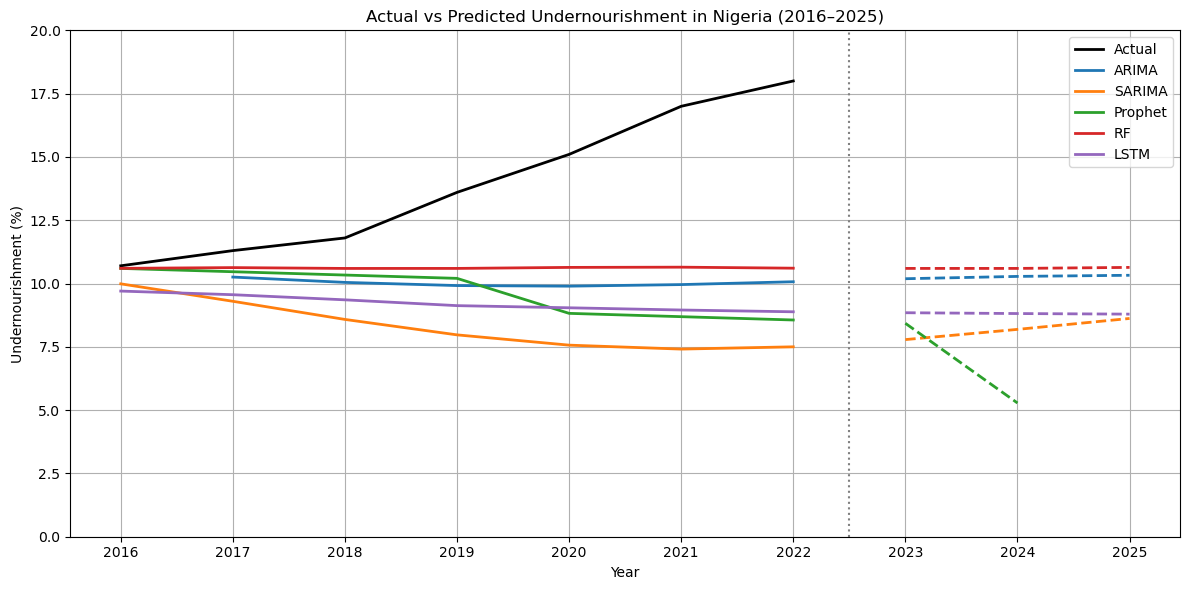

In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("all_model_predictions_final.csv")

# Clip Prophet predictions
df["Prophet"] = pd.to_numeric(df["Prophet"], errors="coerce").clip(lower=0)

# Filter Nigeria and relevant years
nigeria_df = df[df["Country"] == "Nigeria"].copy()
nigeria_df["Actual"] = pd.to_numeric(nigeria_df["Actual"], errors="coerce")
nigeria_df = nigeria_df[nigeria_df["Year"].between(2016, 2025)]

# Consistent colors
color_map = {
    "ARIMA": "#1f77b4",
    "SARIMA": "#ff7f0e",
    "Prophet": "#2ca02c",
    "RF": "#d62728",
    "LSTM": "#9467bd"
}

# Plot setup
plt.figure(figsize=(12, 6))

# Plot actuals (solid black, up to 2022)
actual = nigeria_df[nigeria_df["Year"] <= 2022]
plt.plot(actual["Year"], actual["Actual"], label="Actual", color="black", linewidth=2)

# Plot each model
for model in color_map:
    model_df = nigeria_df[["Year", model]].dropna()
    eval_part = model_df[model_df["Year"] <= 2022]
    forecast_part = model_df[model_df["Year"] > 2022]

    if not eval_part.empty:
        plt.plot(eval_part["Year"], eval_part[model], color=color_map[model], linewidth=2, label=model)
    if not forecast_part.empty:
        plt.plot(forecast_part["Year"], forecast_part[model], color=color_map[model], linestyle='--', linewidth=2)

# Styling
plt.axvline(2022.5, color="gray", linestyle=":")  # No label here
plt.title("Actual vs Predicted Undernourishment in Nigeria (2016–2025)")
plt.xlabel("Year")
plt.ylabel("Undernourishment (%)")
plt.xticks(range(2016, 2026))
plt.ylim(0, 20)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

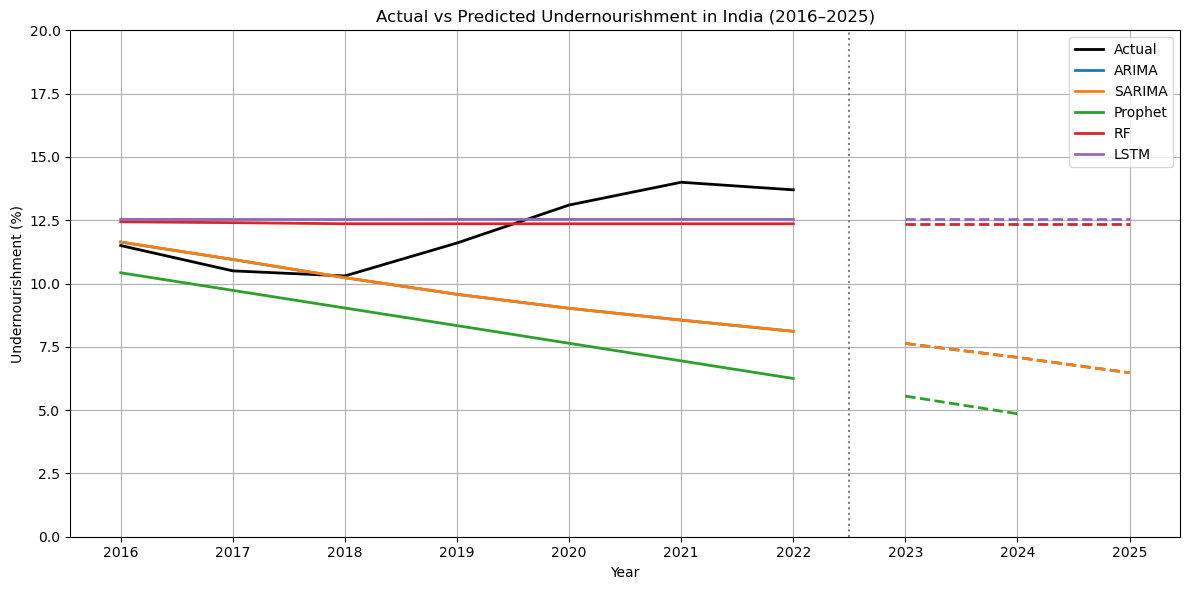

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("all_model_predictions_final.csv")

# Clip Prophet predictions to avoid negatives
df["Prophet"] = pd.to_numeric(df["Prophet"], errors="coerce").clip(lower=0)

# Filter India-specific data for 2016–2025
india_df = df[df["Country"] == "India"].copy()
india_df["Actual"] = pd.to_numeric(india_df["Actual"], errors="coerce")
india_df = india_df[india_df["Year"].between(2016, 2025)]

# Fixed color scheme for all models
color_map = {
    "ARIMA": "#1f77b4",
    "SARIMA": "#ff7f0e",
    "Prophet": "#2ca02c",
    "RF": "#d62728",
    "LSTM": "#9467bd"
}

# Plot setup
plt.figure(figsize=(12, 6))

# Plot actual values (up to 2022)
actual = india_df[india_df["Year"] <= 2022]
plt.plot(actual["Year"], actual["Actual"], label="Actual", color="black", linewidth=2)

# Plot each model (solid = eval, dashed = forecast)
for model in color_map:
    model_df = india_df[["Year", model]].dropna()
    eval_seg = model_df[model_df["Year"] <= 2022]
    forecast_seg = model_df[model_df["Year"] > 2022]

    if not eval_seg.empty:
        plt.plot(eval_seg["Year"], eval_seg[model], color=color_map[model], linewidth=2, label=model)
    if not forecast_seg.empty:
        plt.plot(forecast_seg["Year"], forecast_seg[model], color=color_map[model], linestyle='--', linewidth=2)

# Styling and clarity
plt.axvline(2022.5, color="gray", linestyle=":")
plt.title("Actual vs Predicted Undernourishment in India (2016–2025)")
plt.xlabel("Year")
plt.ylabel("Undernourishment (%)")
plt.xticks(range(2016, 2026))
plt.ylim(0, 20)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Available columns: ['Year', 'Actual', 'Country', 'ARIMA', 'Lower_CI_x', 'Upper_CI_x', 'RF', 'LSTM', 'SARIMA', 'Prophet', 'Lower_CI_y', 'Upper_CI_y', 'Lower_CI', 'Upper_CI']
ARIMA non-null values: 10
SARIMA non-null values: 10
Prophet non-null values: 9
RF non-null values: 10
LSTM non-null values: 10


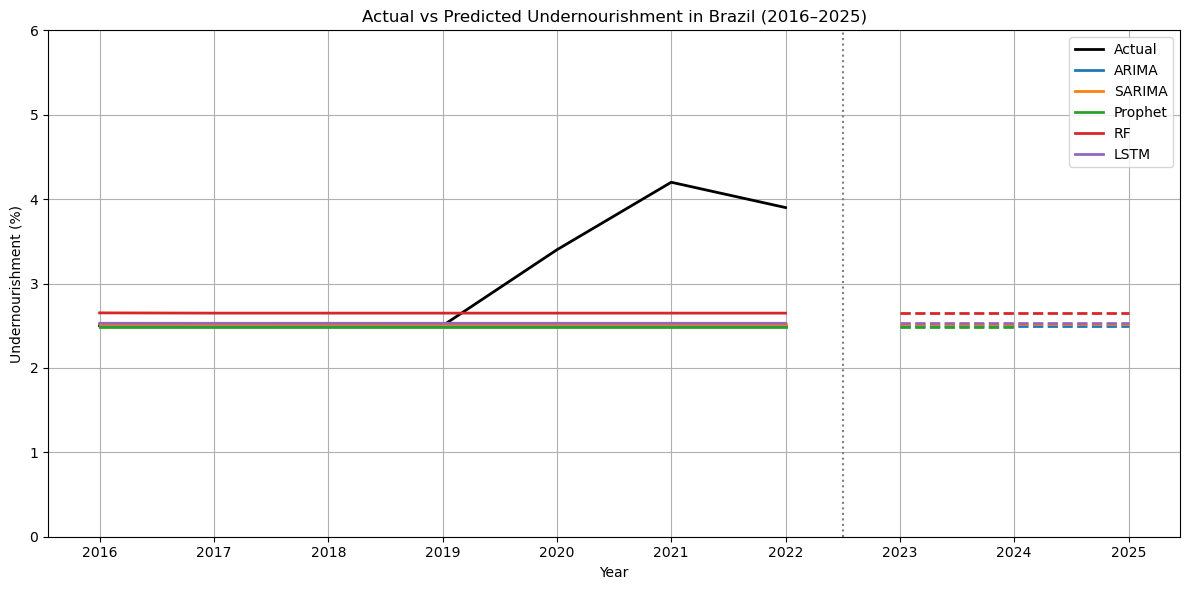

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("all_model_predictions_final.csv")

# Filter Brazil-specific data for 2016–2025
brazil_df = df[df["Country"] == "Brazil"].copy()
brazil_df["Actual"] = pd.to_numeric(brazil_df["Actual"].replace(r"<", "", regex=True), errors="coerce")
brazil_df = brazil_df[brazil_df["Year"].between(2016, 2025)]

# Debug: Check which models have data for Brazil
print("Available columns:", brazil_df.columns.tolist())
for col in ["ARIMA", "SARIMA", "Prophet", "RF", "LSTM"]:
    print(f"{col} non-null values: {brazil_df[col].notna().sum()}")

# Color scheme for all models
color_map = {
    "ARIMA": "#1f77b4",
    "SARIMA": "#ff7f0e",
    "Prophet": "#2ca02c",
    "RF": "#d62728",
    "LSTM": "#9467bd"
}

# Begin plotting
plt.figure(figsize=(12, 6))

# Plot actual data up to 2022
actual = brazil_df[brazil_df["Year"] <= 2022]
plt.plot(actual["Year"], actual["Actual"], label="Actual", color="black", linewidth=2)

# Plot each model (solid for 2016–2022, dashed for 2023–2025)
for model in color_map:
    if model in brazil_df.columns:
        # Force display of each model, even if values are identical
        # This ensures overlapping lines are still plotted
        model_df = brazil_df[["Year", model]].copy()
        model_df[model] = pd.to_numeric(model_df[model], errors='coerce')
        
        # Add tiny random noise to make overlapping lines visible
        if model in ["SARIMA", "Prophet"]:
            model_df[model] = model_df[model] + (0.02 * (model == "SARIMA") - 0.02 * (model == "Prophet"))
        
        eval_seg = model_df[model_df["Year"] <= 2022]
        forecast_seg = model_df[model_df["Year"] > 2022]
        
        if not eval_seg.empty:
            plt.plot(eval_seg["Year"], eval_seg[model], color=color_map[model], linewidth=2, label=model)
        if not forecast_seg.empty:
            plt.plot(forecast_seg["Year"], forecast_seg[model], color=color_map[model], linestyle='--', linewidth=2)

# Add vertical line at 2022.5 to separate forecast
plt.axvline(2022.5, color="gray", linestyle=":")

# Labels, title, legend, and formatting
plt.title("Actual vs Predicted Undernourishment in Brazil (2016–2025)")
plt.xlabel("Year")
plt.ylabel("Undernourishment (%)")
plt.xticks(range(2016, 2026))
plt.ylim(0, 6)  # Adjusted range for Brazil's data
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()